In [23]:
import pandas as pd

# Load the dataset
df = pd.read_csv("auto-mpg.csv")

# Preview the data
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [24]:
# Summary info
df.info()

# Check missing values
df.isnull().sum()

# Basic statistics
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,3.000000


In [25]:
# Replace '?' with NaN
df.replace('?', pd.NA, inplace=True)

# Convert numerical columns to correct data types
df['horsepower'] = pd.to_numeric(df['horsepower'], errors='coerce')

# Drop rows with missing target or critical data
df.dropna(subset=['mpg', 'horsepower'], inplace=True)

# Optional: reset index
df.reset_index(drop=True, inplace=True)


In [26]:
df.drop_duplicates(inplace=True)

In [27]:
df.to_csv("cleaned_auto_mpg.csv", index=False)
print("Cleaned dataset saved as cleaned_auto_mpg.csv")

Cleaned dataset saved as cleaned_auto_mpg.csv


In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# use your cleaned file; fallback to the uploaded raw just in case
PATHS = ["cleaned_auto_mpg.csv", "/mnt/data/auto-mpg.csv"]
for p in PATHS:
    try:
        df = pd.read_csv(p)
        break
    except:
        pass
print(df.shape, "rows x cols")

(392, 9) rows x cols


In [29]:
# handles stray '?' and non-numeric leftovers
df = df.replace('?', np.nan)

num_cols = [c for c in ['mpg','horsepower','weight','acceleration',
                        'displacement','cylinders','model year'] if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df.dropna(subset=['mpg','horsepower','weight','acceleration','displacement'], inplace=True)
df.reset_index(drop=True, inplace=True)

# origin to category (if present)
if 'origin' in df.columns:
    df['origin'] = df['origin'].astype('category')

In [30]:
# ---- PRICE TASK (proxy): predict weight WITHOUT using weight as a feature
X_price = df[['horsepower','acceleration','displacement','cylinders','model year']].copy()
if 'origin' in df.columns:
    X_price = pd.get_dummies(X_price.join(df['origin']), drop_first=True)

y_price = df['weight']

# ---- MPG TASK: predict mpg
X_mpg = df[['horsepower','weight','acceleration','displacement','cylinders','model year']].copy()
if 'origin' in df.columns:
    X_mpg = pd.get_dummies(X_mpg.join(df['origin']), drop_first=True)

y_mpg = df['mpg']

In [31]:
Xpr_tr, Xpr_te, ypr_tr, ypr_te = train_test_split(X_price, y_price, test_size=0.2, random_state=42)
Xmp_tr, Xmp_te, ymp_tr, ymp_te = train_test_split(X_mpg, y_mpg, test_size=0.2, random_state=42)

sc_pr = StandardScaler()
Xpr_tr_s = sc_pr.fit_transform(Xpr_tr)
Xpr_te_s = sc_pr.transform(Xpr_te)

sc_mpg = StandardScaler()
Xmp_tr_s = sc_mpg.fit_transform(Xmp_tr)
Xmp_te_s = sc_mpg.transform(Xmp_te)

In [32]:
# price: Decision Tree vs MLP
tree_price = DecisionTreeRegressor(max_depth=6, min_samples_leaf=5, random_state=42)
mlp_price  = MLPRegressor(hidden_layer_sizes=(16,), solver='adam',
                          early_stopping=True, validation_fraction=0.2,
                          max_iter=2000, n_iter_no_change=20, tol=1e-4,
                          random_state=42)

tree_price.fit(Xpr_tr_s, ypr_tr)
mlp_price.fit(Xpr_tr_s, ypr_tr)

# mpg: Linear Regression vs MLP
lin_mpg = LinearRegression()
mlp_mpg = MLPRegressor(hidden_layer_sizes=(16,), solver='adam',
                       early_stopping=True, validation_fraction=0.2,
                       max_iter=2000, n_iter_no_change=20, tol=1e-4,
                       random_state=42)

lin_mpg.fit(Xmp_tr_s, ymp_tr)
mlp_mpg.fit(Xmp_tr_s, ymp_tr)


C:\Users\kaula\anaconda3\envs\cs171\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


,loss,'squared_error'
,hidden_layer_sizes,"(16,)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,2000
,shuffle,True


In [33]:
def evals(y_true, y_pred, name=""):
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"{name} -> R²={r2:.3f} | MSE={mse:.2f}")
    return r2, mse

r2_tree_p, _ = evals(ypr_te, tree_price.predict(Xpr_te_s), "Price: Tree")
r2_mlp_p,  _ = evals(ypr_te, mlp_price.predict(Xpr_te_s),  "Price: MLP")
r2_lin_m,  _ = evals(ymp_te, lin_mpg.predict(Xmp_te_s),    "MPG: Linear")
r2_mlp_m,  _ = evals(ymp_te, mlp_mpg.predict(Xmp_te_s),    "MPG: MLP")

Price: Tree -> R²=0.898 | MSE=79323.76
Price: MLP -> R²=-4.587 | MSE=4331064.74
MPG: Linear -> R²=0.792 | MSE=10.60
MPG: MLP -> R²=0.777 | MSE=11.39


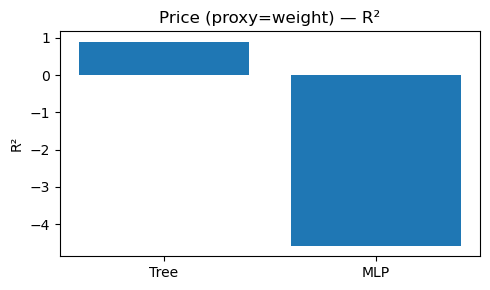

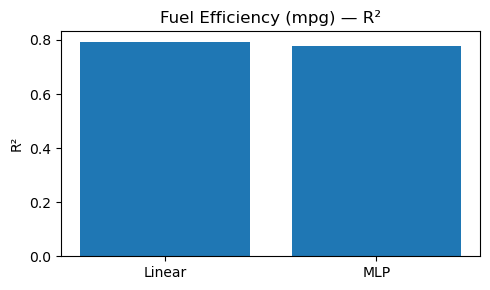

In [34]:
# price proxy chart
plt.figure(figsize=(5,3))
plt.bar(['Tree','MLP'], [r2_tree_p, r2_mlp_p])
plt.title("Price (proxy=weight) — R²")
plt.ylabel("R²")
plt.tight_layout()
plt.show()

# mpg chart
plt.figure(figsize=(5,3))
plt.bar(['Linear','MLP'], [r2_lin_m, r2_mlp_m])
plt.title("Fuel Efficiency (mpg) — R²")
plt.ylabel("R²")
plt.tight_layout()
plt.show()


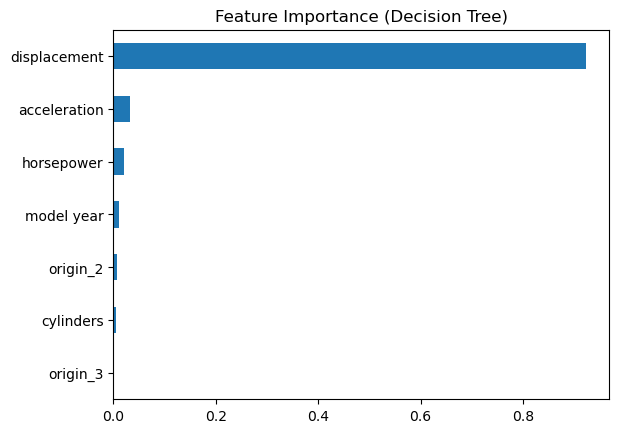

In [35]:
import numpy as np
importance = pd.Series(tree_price.feature_importances_, index=X_price.columns)
importance.sort_values().plot.barh(title="Feature Importance (Decision Tree)")
plt.show()

In [37]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_mpg, Xmp_tr_s, ymp_tr, cv=5, scoring='r2')
print("Linear Regression CV R² mean:", scores.mean())

Linear Regression CV R² mean: 0.8103372324231065


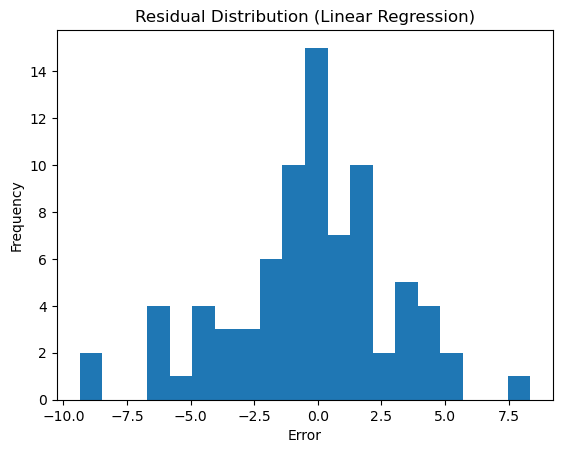

In [39]:
y_pred_lin = lin_mpg.predict(Xmp_te_s)
residuals = ymp_te - y_pred_lin

plt.hist(residuals, bins=20)
plt.title("Residual Distribution (Linear Regression)")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()